# Data Preprocessing

## Import the libraries

In [208]:
!pip install ibm-cos-sdk | grep -v 'already satisfied'
import ibm_boto3
from ibm_botocore.client import Config
import pandas as pd
import numpy as np
import io, datetime
import matplotlib.pyplot as plt
import os, types
from botocore.client import Config
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler


## Importing the dataset

In [209]:
# The code was removed by Watson Studio for sharing.

,date,price
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


## Handling missing data

In [210]:
df.isnull().any()

date     False
price     True
dtype: bool

In [211]:
df.dropna(axis=0,inplace=True)
df.isnull().any()

date     False
price    False
dtype: bool

In [212]:
df.shape

(8216, 2)

## Data visualization

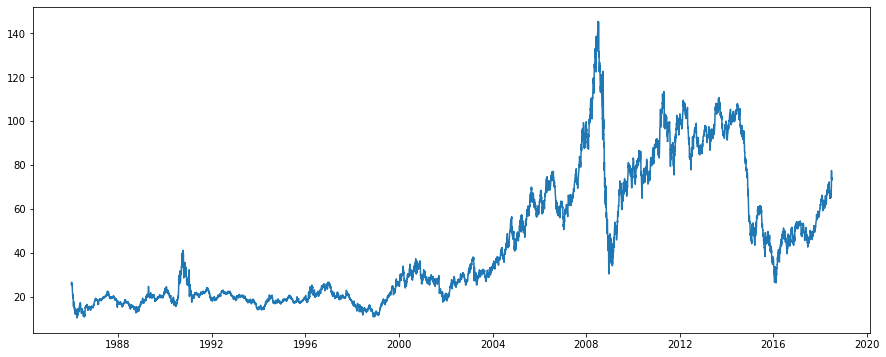

In [213]:
plot = plt.figure(figsize=(15, 6))
time = pd.to_datetime(df['date'])
price = list(df['price'])
data = pd.Series(price, time)
plt.plot(data)

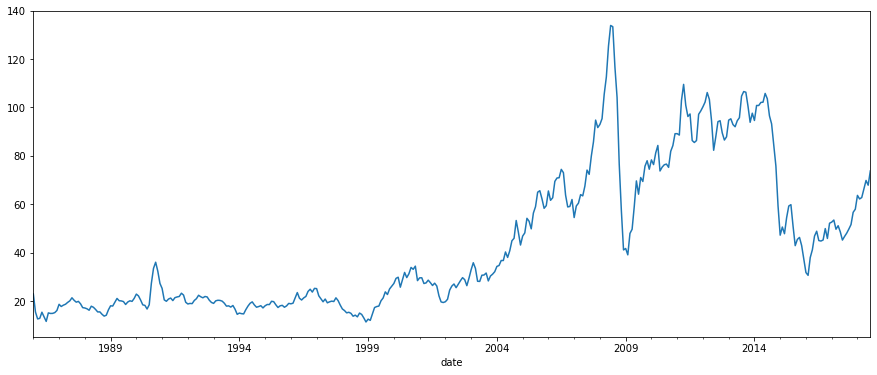

In [214]:
#Decompose the plot
df.set_index('date', inplace=True)
y = df['price'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

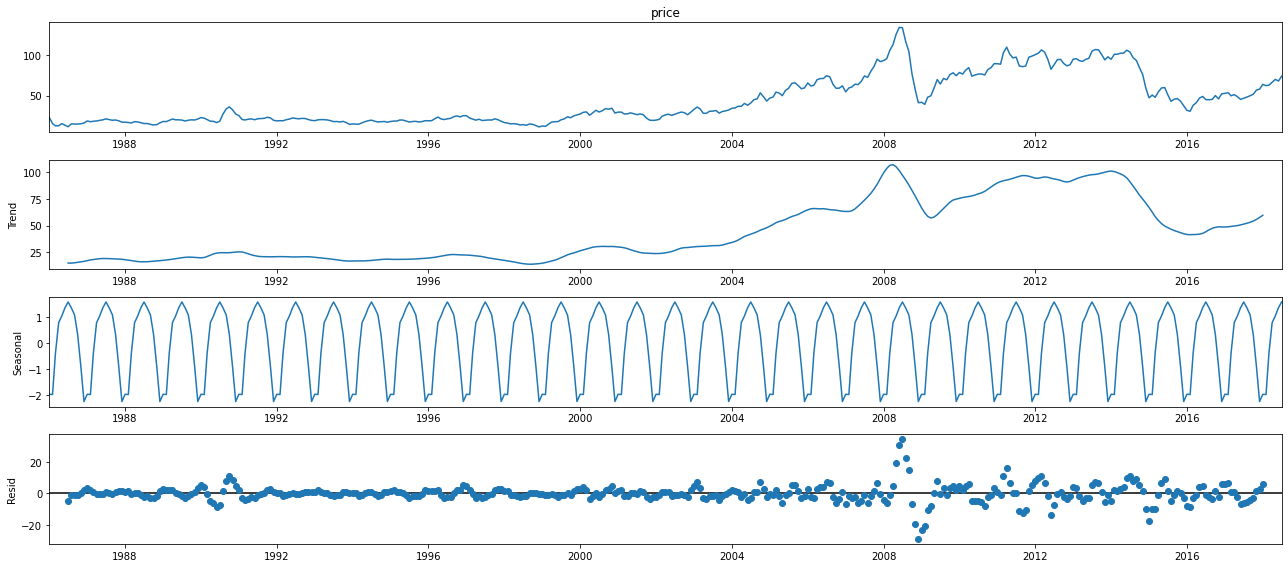

In [215]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Feature Scaling


In [216]:
df1 = df.reset_index()['price']
sc = MinMaxScaler(feature_range = (0, 1))
df1 = sc.fit_transform(np.array(df1).reshape(-1,1))

In [217]:
df1.shape

(8216, 1)

## Train Test Split

In [218]:
train_size = int(len(df1) * 0.80)
test_size = len(df1) - train_size
train, test = df1[0:train_size, :], df1[train_size:len(df1), :]

In [219]:
len(test)

1644

## Creating Window

In [220]:
def dataset(df, lookback=1):
    data_x, data_y = [], []
    for i in range(len(df) - lookback - 1):
        a = df[i:(i + lookback), 0]
        data_x.append(a)
        data_y.append(df[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

time_step = 10
# Reshape into X=t and Y=t+1
X_train , Y_train = dataset(train,time_step)
X_test , Y_test = dataset(test,time_step)
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [221]:
X_train.shape

(6561, 10, 1)

# **Model Building**

## Import the Model building libraries

In [222]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

##  Model


In [223]:
model = Sequential()
model.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(units = 10, return_sequences = True))
model.add(LSTM(units = 10))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 10, 10)            480       
                                                                 
 lstm_16 (LSTM)              (None, 10, 10)            840       
                                                                 
 lstm_17 (LSTM)              (None, 10)                840       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,171
Trainable params: 2,171
Non-trainable params: 0
_________________________________________________________________


In [224]:
# 1st LSTM Layer 
print(4 * 10 * (1 + 10 + 1))

480


In [225]:
# 2nd LSTM Layer 
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


## Configure the Learning Process

In [226]:
history = model.fit(X_train, Y_train, epochs = 30, batch_size = 64,validation_data=(X_test, Y_test),verbose=2)

Epoch 1/30
103/103 - 6s - loss: 0.0134 - val_loss: 4.8517e-04 - 6s/epoch - 56ms/step
Epoch 2/30
103/103 - 1s - loss: 4.1906e-04 - val_loss: 5.2644e-04 - 1s/epoch - 13ms/step
Epoch 3/30
103/103 - 1s - loss: 4.0692e-04 - val_loss: 4.8744e-04 - 1s/epoch - 10ms/step
Epoch 4/30
103/103 - 1s - loss: 3.9599e-04 - val_loss: 5.0753e-04 - 1s/epoch - 12ms/step
Epoch 5/30
103/103 - 1s - loss: 3.8158e-04 - val_loss: 4.5745e-04 - 1s/epoch - 14ms/step
Epoch 6/30
103/103 - 1s - loss: 3.7509e-04 - val_loss: 5.0359e-04 - 1s/epoch - 12ms/step
Epoch 7/30
103/103 - 1s - loss: 3.6603e-04 - val_loss: 4.7040e-04 - 1s/epoch - 10ms/step
Epoch 8/30
103/103 - 1s - loss: 3.6063e-04 - val_loss: 4.4497e-04 - 1s/epoch - 14ms/step
Epoch 9/30
103/103 - 1s - loss: 3.5517e-04 - val_loss: 4.5934e-04 - 1s/epoch - 14ms/step
Epoch 10/30
103/103 - 1s - loss: 3.6746e-04 - val_loss: 5.1494e-04 - 1s/epoch - 13ms/step
Epoch 11/30
103/103 - 1s - loss: 3.3927e-04 - val_loss: 4.4264e-04 - 1s/epoch - 10ms/step
Epoch 12/30
103/103 - 1

## Train the model

In [186]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [187]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

## Model evaluation

In [188]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 1.4864362032575915
Train Root Mean Squared Error: 2.3378447818172226
Test Mean Absolute Error: 2.3797633480952696
Test Root Mean Squared Error: 3.0107626907361675


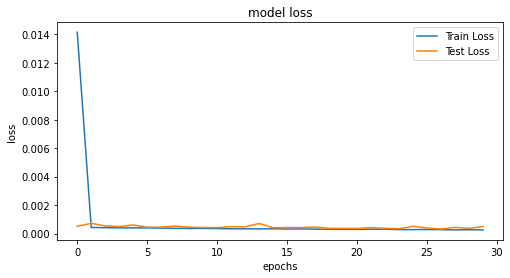

In [189]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

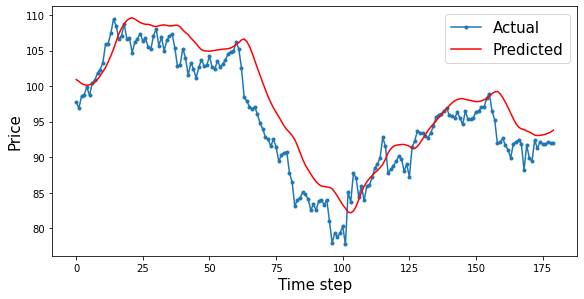

In [190]:
data = [i for i in range(180)]
plt.figure(figsize=(8,4))
plt.plot(data, Y_test[0][:180], marker='.', label="Actual")
plt.plot(data, test_predict[:,0][:180], 'r', label="Predicted")
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## Save the model

In [191]:
model.save("model.h5")
!tar -zcvf model.tgz model.h5

model.h5


In [192]:
##  IBM WATSON Deployment

In [193]:
!pip install ibm_watson_machine_learning watson-machine-learning-client | grep -v 'already satisfied'

In [194]:
# The code was removed by Watson Studio for sharing.

In [195]:
def guid_from_space_name(client,space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])

In [196]:
space_uid = guid_from_space_name(client,'model')
print("Space - {}".format(space_uid))

Space - 96f2c14a-ab58-473d-b306-13b0bb073d55


In [197]:
client.set.default_space(space_uid)

'SUCCESS'

In [198]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [199]:
software_spec_uid = client.software_specifications.get_uid_by_name("tensorflow_rt22.1-py3.9")
software_spec_uid

'acd9c798-6974-5d2f-a657-ce06e986df4d'

In [200]:
model_details = client.repository.store_model(model = "model.tgz",meta_props={
    client.repository.ModelMetaNames.NAME:"CrudeOil Price Prediction",
    client.repository.ModelMetaNames.TYPE:"tensorflow_2.7",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid
})
model_id = client.repository.get_model_id(model_details)

In [201]:
model_id = client.repository.get_model_id(model_details)
model_id

'bda6f8d1-c5de-4a72-89d7-6bd98f4366ed'

In [202]:
client.repository.download(model_id,'ibm_model.h5')

Successfully saved model content to file: 'ibm_model.h5'


'/home/wsuser/work/ibm_model.h5'

## Test the model

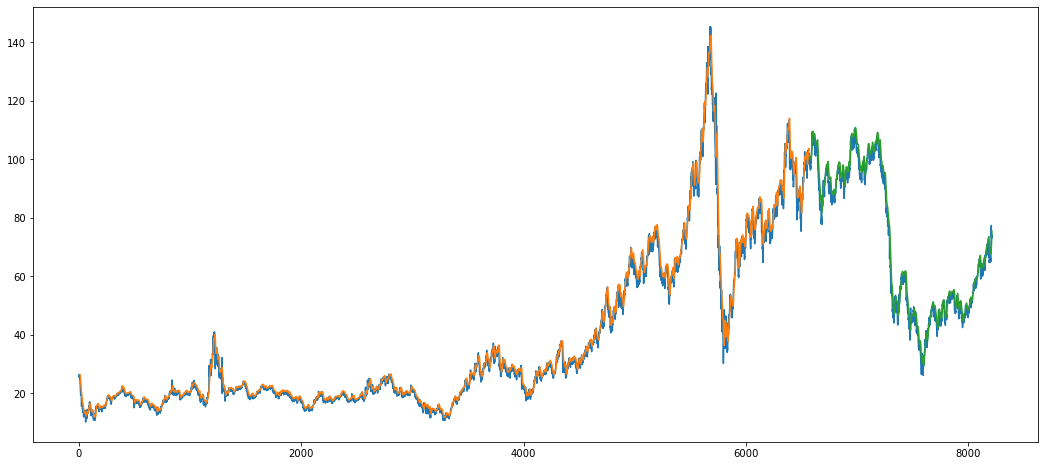

In [203]:
# Model Testing
look_back = 10
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] = test_predict
plt.plot(sc.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [204]:
x_input = test[len(test)-10:].reshape(1,-1)
x_input.shape

(1, 10)

In [205]:
temp_input = list(x_input[0])
temp_list = temp_input[0].tolist()

In [206]:
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [207]:
lst_output = []
n_steps = 10
i = 0
while(i<10):
  if(len(temp_input) > 10):
    x_input = np.array(temp_input[1:])
    print("Day {} Input {}".format(i,x_input),end="\n")
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose=0)
    print("Day {} Output {}".format(i,yhat),end="\n")
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    print("------------------------",end="\n")
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose=0)
    print("Day {} output {}".format(i,yhat),end="\n")
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i = i+1

Day 0 output [[0.48740205]]
Day 1 Input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.46497853 0.47038353 0.47149415 0.48740205]
Day 1 Output [[0.4890242]]
------------------------
Day 2 Input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.46497853
 0.47038353 0.47149415 0.48740205 0.48902419]
Day 2 Output [[0.48988143]]
------------------------
Day 3 Input [0.46794017 0.47297497 0.47119799 0.47341922 0.46497853 0.47038353
 0.47149415 0.48740205 0.48902419 0.48988143]
Day 3 Output [[0.4910692]]
------------------------
Day 4 Input [0.47297497 0.47119799 0.47341922 0.46497853 0.47038353 0.47149415
 0.48740205 0.48902419 0.48988143 0.4910692 ]
Day 4 Output [[0.49397087]]
------------------------
Day 5 Input [0.47119799 0.47341922 0.46497853 0.47038353 0.47149415 0.48740205
 0.48902419 0.48988143 0.4910692  0.49397087]
Day 5 Output [[0.4968828]]
------------------------
Day 6 Input [0.47341922 0.46497853 0.47038353 0.47149415 0.48740205 0.48902419
 0.489